# Práctica Extra

En esta práctica extra se proponen ejercicios que integran y combinan los contenidos trabajados en las prácticas anteriores.  
Algunos ejercicios presentan un nivel de dificultad más alto y están pensados para **reforzar y afianzar los conceptos** una vez que se hayan completado y comprendido las prácticas previas.

In [74]:
# Imports
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Ejercicio 1

En este ejercicio se propone aplicar un **filtro gaussiano de suavizado** sobre una imagen en color.

El objetivo es comparar **dos formas equivalentes** de realizar la convolución:
1. Filtrando **cada canal (B, G, R)** por separado y después combinándolos.
2. Creando una versión del filtro que **procesa directamente una imagen RGB**, aplicando la convolución dentro de la misma función.

### Pasos:
1. Generar una **máscara gaussiana** con el tamaño y sigma indicados.
2. Implementar una función `filtro(imagen, mascara)` para el caso de una sola banda.
3. Extender la función a `filtro_rgb(imagen, mascara)` para trabajar directamente con imágenes en color.
4. Aplicar ambas versiones y comparar los resultados visualmente.


In [75]:
# Filtro gaussiano
n = 11 #tamaño del filtro
sigma = 3 #desviación de la gaussiana
mask = cv2.getGaussianKernel(n, sigma)*cv2.getGaussianKernel(n, sigma).T

In [76]:
def filtro(imagen, mascara):
    n,m = mascara.shape[0]//2, mascara.shape[1]//2
    imagen_amp = cv2.copyMakeBorder(imagen, n,n,m,m,cv2.BORDER_REPLICATE)
    imagen_f = np.zeros_like(imagen,dtype=np.float32)

    for i in range(n, imagen.shape[0]+n):
        for j in range(m,imagen.shape[1]+m):
            ventana = imagen_amp[i-n:i+n+1,j-m:j+m+1]
            imagen_f[i-n,j-m] = np.sum(ventana * mascara)
            
    
    return imagen_f.astype(np.uint8)

In [77]:
def filtro_rgb(imagen, mascara):
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB) #RGB
    
    canal_rojo,canal_verde,canal_azul = imagen[:,:,0],imagen[:,:,1],imagen[:,:,2]

    filtro_rojo = filtro(canal_rojo,mascara)
    filtro_verde = filtro(canal_verde,mascara)
    filtro_azul = filtro(canal_azul,mascara)

    imagen_f = cv2.merge([filtro_rojo,filtro_verde,filtro_azul])

    return imagen_f.astype(np.uint8)

(-0.5, 939.5, 664.5, -0.5)

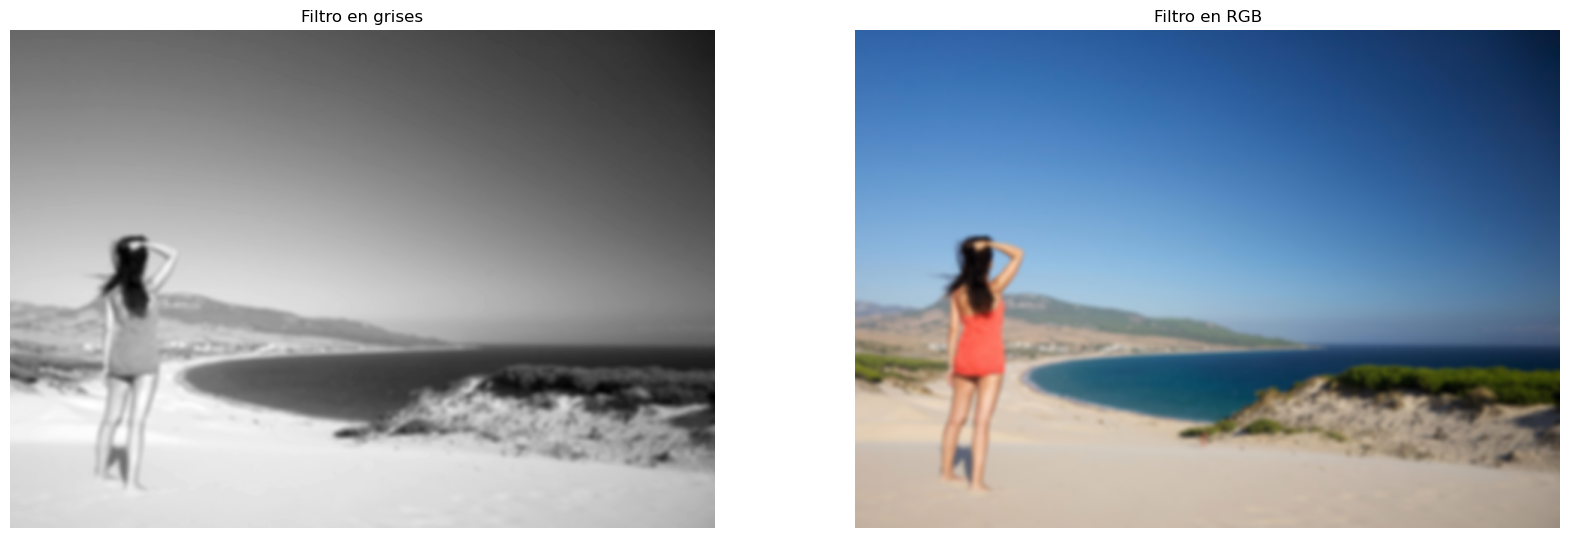

In [78]:
imagen_GRAY = cv2.imread('images/playa.jpg',0)
imagen_GRAY = filtro(imagen_GRAY,mask)

imagen_BGR = cv2.imread('images/playa.jpg') #(665,940,3)
imagen_RGB = filtro_rgb(imagen_BGR, mask)

fig,axes = plt.subplots(1,2,figsize=(20,20))

axes[0].imshow(imagen_GRAY,cmap='gray')
axes[0].set_title("Filtro en grises")
axes[0].axis('off')

axes[1].imshow(imagen_RGB)
axes[1].set_title("Filtro en RGB")
axes[1].axis('off')



# Ejercicio 2

En este ejercicio se implementa un filtro que actúa **únicamente dentro de una región específica de la imagen** (un cuadrado central), dejando el resto sin modificar.

### Pasos:
1. Leer una imagen y obtener su tamaño.
2. Definir las **coordenadas del cuadrado** centrado en la imagen y dibujarlo para comprobar su posición.
3. Implementar una función `filtro_roi(imagen, mascara, mask_bin)` que aplique el filtro a la imagen solo dentro de la máscara.
4. Aplicar el filtro a cada canal (B, G y R) y combinar los resultados.
5. Mostrar la **imagen original** y la **imagen filtrada solo en el cuadrado** para comparar.


In [79]:
def filtro_roi(imagen, mascara, mask_bin):
    n,m = mascara.shape[0]//2, mascara.shape[1]//2
    imagen_amp = cv2.copyMakeBorder(imagen, n,n,m,m,cv2.BORDER_REPLICATE)
    out = np.zeros_like(imagen)

    for i in range(n,imagen.shape[0]+n):
        for j in range(m, imagen.shape[1]+m):
            if mask_bin[i-n,j-m]==1:
                ventana = imagen_amp[i-n:i+n+1,j-m:j+m+1]
                out[i-n,j-m] = np.sum(ventana * mascara)
            else:
                out[i-n,j-m] = imagen_amp[i,j]              

    return out.astype(np.uint8)


In [80]:
# Filtro gaussiano
n = 11 #tamaño del filtro
sigma = 3 #desviación de la gaussiana
mask = cv2.getGaussianKernel(n, sigma)*cv2.getGaussianKernel(n, sigma).T

(-0.5, 939.5, 664.5, -0.5)

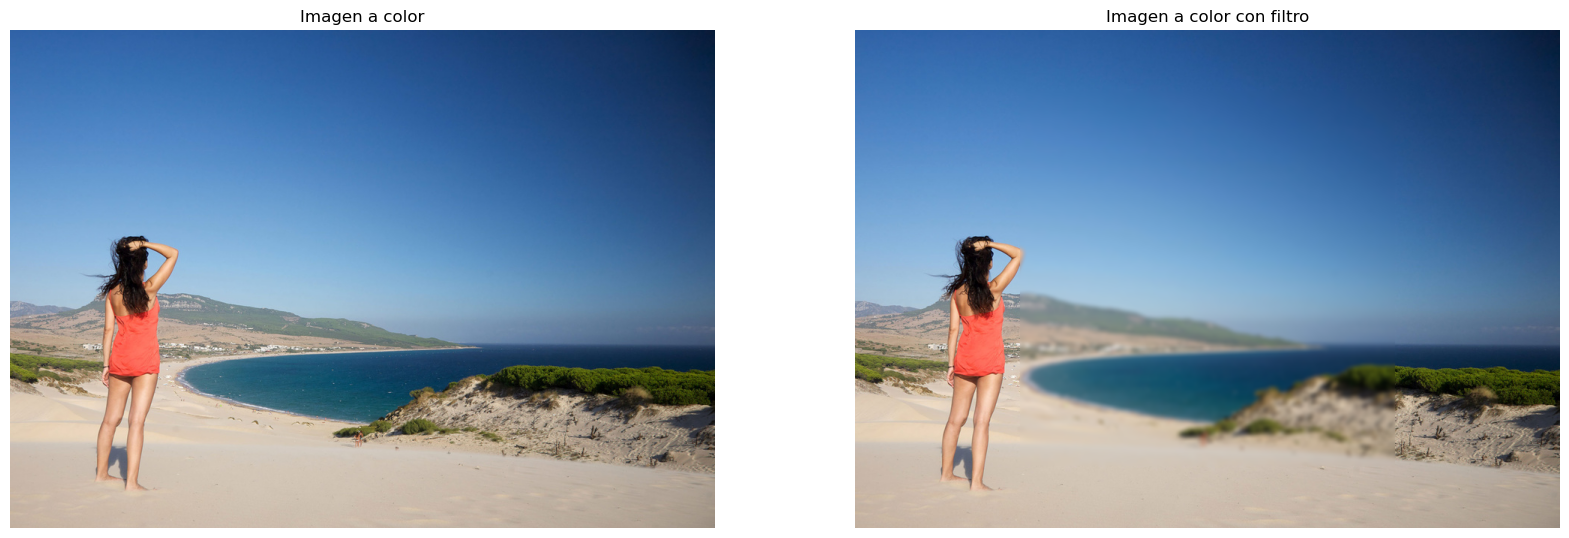

In [81]:
imagen = cv2.imread('images/playa.jpg')
imagen_RGB = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

canal_rojo = imagen_RGB[:,:,0]
canal_verde = imagen_RGB[:,:,1]
canal_azul = imagen_RGB[:,:,2]

mask_bin = np.zeros_like(imagen[:,:,0])

lado = 500 //2
central_y,central_x = imagen_RGB.shape[0]//2, imagen_RGB.shape[1]//2

mask_bin[central_y-lado:central_y+lado,central_x-lado:central_x+lado] = 1

filtro_rojo = filtro_roi(canal_rojo,mask,mask_bin)
filtro_verde = filtro_roi(canal_verde,mask,mask_bin)
filtro_azul = filtro_roi(canal_azul,mask,mask_bin)

imagen_final = cv2.merge((filtro_rojo,filtro_verde,filtro_azul))

fig, axes = plt.subplots(1,2,figsize=(20,20))

axes[0].imshow(imagen_RGB)
axes[0].set_title("Imagen a color")
axes[0].axis('off')

axes[1].imshow(imagen_final)
axes[1].set_title("Imagen a color con filtro")
axes[1].axis('off')






# Ejercicio 3

A partir de la imagen suavizada, se desea combinarla con la imagen original de manera que **solo una región circular central** mantenga el aspecto original, mientras que el resto de la imagen permanezca suavizado.

### Pasos:
1. Crear una **máscara circular** centrada en la imagen (por ejemplo, de radio 300–400 píxeles, comprueba el tamaño pintando el círculo en la imagen).
2. Utilizar dicha máscara para **fusionar** las dos imágenes:
   - Dentro del círculo → conservar la imagen original.
   - Fuera del círculo → mantener la imagen suavizada.
3. Implementar **dos versiones**:
   - Una **sin bucle `for`**, usando operaciones lógicas y funciones de OpenCV (`bitwise_and`, `bitwise_or`, `bitwise_not`).
   - Otra **con bucles anidados**, recorriendo todos los píxeles de la imagen manualmente.
4. Mostrar el resultado y comparar ambas implementaciones.

(-0.5, 939.5, 664.5, -0.5)

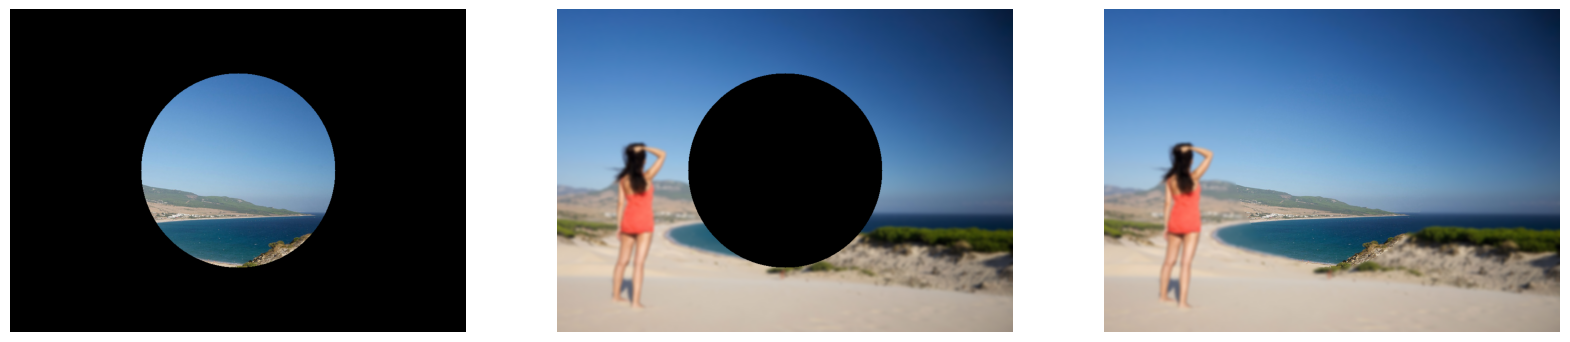

In [90]:
imagen = cv2.imread('images/playa.jpg')
imagen_RGB = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)


#Creamos le circle
mask_aux = np.zeros_like(imagen[:,:,0])
c_y,c_x = mask_aux.shape[0]//2, mask_aux.shape[1]//2
cv2.circle(mask_aux, (c_x,c_y),200, 255,-1)

resultado1 = cv2.bitwise_and(imagen_RGB, imagen_RGB,mask=mask_aux)

imagen_suavizada = filtro_rgb(imagen_RGB,mask)
mask_invertida = cv2.bitwise_not(mask_aux)

resultado2 = cv2.bitwise_and(imagen_suavizada, imagen_suavizada, mask=mask_invertida)
resultado2 = cv2.cvtColor(resultado2, cv2.COLOR_BGR2RGB)

resultado3 = cv2.bitwise_or(resultado1,resultado2)

fig,axes = plt.subplots(1,3,figsize=(20,20))

axes[0].imshow(resultado1)
axes[0].axis('off')

axes[1].imshow(resultado2)
axes[1].axis('off')

axes[2].imshow(resultado3)
axes[2].axis('off')

# Ejercicio 4

En este ejercicio se propone aplicar una **cuantización de intensidades** para obtener un efecto tipo *cómic* o *posterizado*, reduciendo el número de niveles de gris o de color en la imagen.

### Pasos:
1. Implementar una función `cuantizar_bw(img, niveles)` que divida los valores de intensidad en un número fijo de **niveles discretos** y los sustituya por el **límite superior** del intervalo correspondiente.
   Por ejemplo, si se eligen **2 niveles**, el rango de intensidades `[0–255]` se divide en dos partes:  
   - píxeles entre `0–127` pasan a tener el valor **127**,  
   - píxeles entre `128–255` pasan a **255**.  

   Si se eligen **4 niveles**, los intervalos serían:
   - `0–63`  → 63
   - `64–127` → 127 
   - `128–191` → 191  
   - `192–255` → 255  
2. Implementar una versión `cuantizar_color(img, niveles)` que repita el mismo proceso en cada canal (B, G, R) de forma independiente.
3. Probar la cuantización sobre:
   - Una imagen suavizada en color.
   - Una imagen en blanco y negro.
4. Visualizar los resultados para distintos valores de niveles (`2`, `8`, `16`, ...), observando cómo el número de tonos disminuye y aparece un efecto *cartoon* o de *posterización*.

![Comic | 100](images/comic.png)


In [126]:
def cuantizar_bw(img, niveles):
    out = np.zeros_like(img)
    step = 255/niveles
    aux1 = np.arange(0,256,step).astype(np.uint8)
    aux2 = aux1[1:]+1

    for i in range(0, img.shape[0]):
        for j in range(0,img.shape[1]):
            for k in range(0,niveles):
                if img[i,j] >=aux1[k] and img[i,j]< aux2[k]:
                    out[i,j] = aux2[k]

    return out.astype(np.uint8)


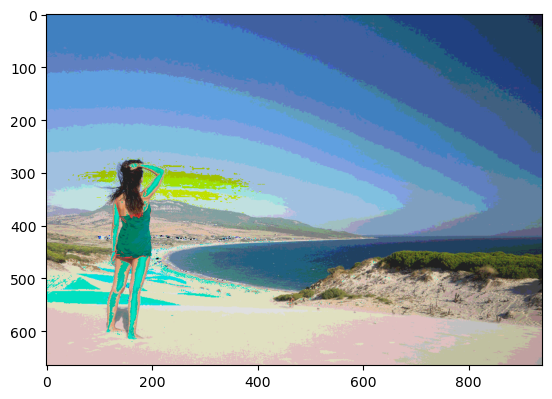

In [127]:
imagen = cv2.imread('images/playa.jpg')
imagen_RGB = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

canal_rojo = imagen_RGB[:,:,0]
canal_verde = imagen_RGB[:,:,1]
canal_azul = imagen_RGB[:,:,2]

filtro_rojo = cuantizar_bw(canal_rojo,8)
filtro_verde = cuantizar_bw(canal_verde,8)
filtro_azul = cuantizar_bw(canal_azul,8)

imagen_final = cv2.merge((filtro_rojo,filtro_verde, filtro_azul))


plt.imshow(imagen_final)

In [84]:
def cuantizar_color(img, niveles):

    return out


# Ejercicio 5

En este ejercicio se crea un **efecto de difuminado entre una imagen en blanco y negro y su versión en color**.  
El objetivo es generar una **transición progresiva** (de izquierda a derecha) en la que la imagen pasa de escala de grises a color completo, usando una **máscara de mezcla** con valores que van de 0 a 1.

### Pasos:
1. Leer una imagen a color.
2. Convertirla a **escala de grises** y repetirla en los tres canales (para poder mezclarla con la de color).
3. Crear una **máscara horizontal `alpha_h`** que varía de 0 (gris) a 1 (color). Pista: recuerda la función `np.linspace`
4. Mezclar las dos imágenes píxel a píxel con la fórmula:

   $$
   \text{resultado} = (1 - \alpha)\cdot\text{gris} + \alpha\cdot\text{color}
   $$

   El valor de $\alpha$ varía entre 0 y 1 a lo largo de la imagen, controlando cuánto color se añade en cada zona:
   - Si $\alpha = 0$, el píxel es totalmente gris.  
   - Si $\alpha = 1$, el píxel es completamente en color.  
   - En valores intermedios, se obtiene una mezcla proporcional de ambos.

   Como el gris tiene los tres canales iguales y el color distintos valores en cada canal, al aumentar $\alpha$ la imagen pasa gradualmente de tonos neutros a color real.
5. Visualizar el resultado mostrando la transición “**Gris → Color**”.

![Difuminado gris a color | 100](images/difuminado.png)


(-0.5, 939.5, 664.5, -0.5)

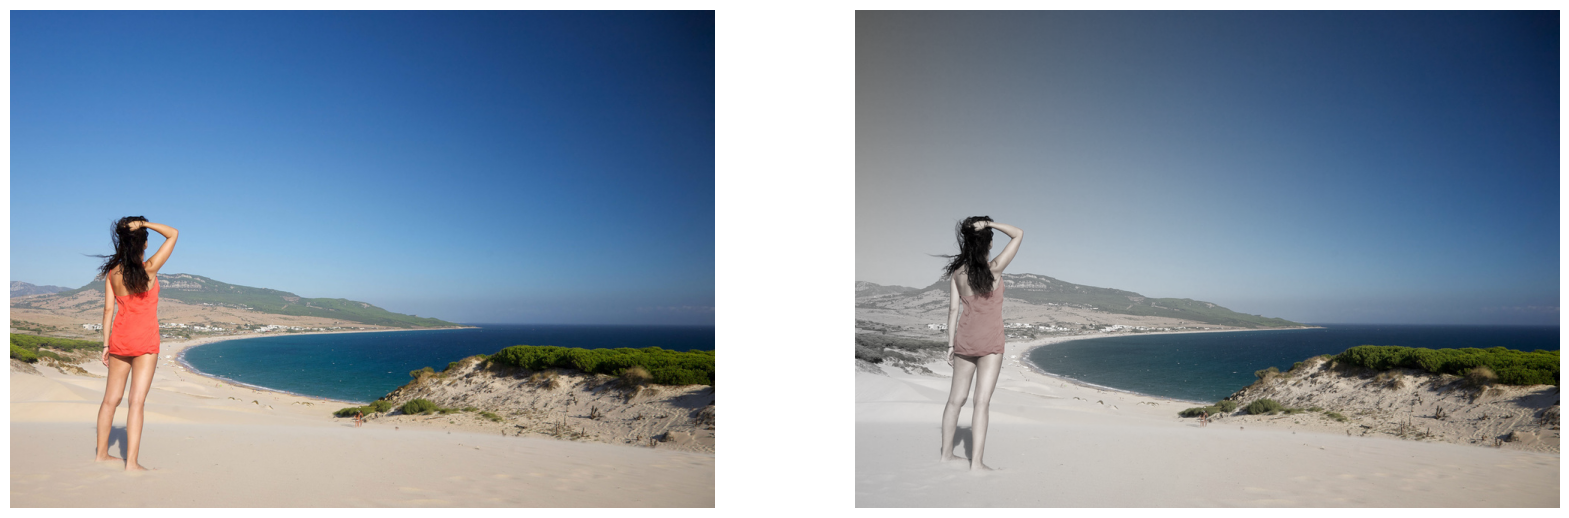

In [148]:
imagen_color = cv2.imread('images/playa.jpg')

images_grises = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2GRAY)
imagen_color = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB)
imagen_grises_canales = cv2.merge((images_grises,images_grises,images_grises))

alpha_h = np.linspace(0,1,imagen_color.shape[1]).reshape(1,-1)
alpha_h = np.repeat(alpha_h,imagen_color.shape[0],axis=0)

alpha_h = alpha_h[:,:,np.newaxis]

resultado = (1 - alpha_h) * imagen_grises_canales + alpha_h * imagen_color

fig,axes = plt.subplots(1,2,figsize=(20,20))

axes[0].imshow(imagen_color)
axes[0].axis('off')
axes[1].imshow(resultado.astype(np.uint8))
axes[1].axis('off')